<a href="https://colab.research.google.com/github/vrmusketeers/DeepLearningProject/blob/main/notebooks/Train_VAE_and_DALLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [ ]:
!pip install dalle-pytorch --upgrade
!pip install wandb

     |████████████████████████████████| 1.4MB 7.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 1.7MB 15.3MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 2.1MB 52.4MB/s 
     |████████████████████████████████| 3.3MB 52.6MB/s 
     |████████████████████████████████| 849kB 47.2MB/s 
     |████████████████████████████████| 21.6MB 1.5MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 901kB 54.8MB/s 
     |████████████████████████████████| 276kB 55.7MB/s 
     |████████████████████████████████| 112kB 53.8MB/s 
     |████████████████████████████████| 829kB 35.6MB/s 
     |████████████████████████████████| 184kB 48.7MB/s 
     |████████████████████████████████| 747kB 47.0MB/s 
     |████████████████████████████████| 1.9MB 44.3MB/s 
     |████████████████████████████████| 1.3MB 43.8MB/s 
     |████████████████████████████████| 296kB 54.5MB/s 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wandb
!wandb login

     |████████████████████████████████| 2.1MB 7.5MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 163kB 36.2MB/s 
     |████████████████████████████████| 133kB 26.9MB/s 
     |████████████████████████████████| 133kB 28.5MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=ec8d42c0c7542cfc418619c4c1646ba8cccef332bdd9ef3459c212f662360300
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=43acc8322e965db2b72daf0d5652b7f045e44587cafaa19bb38959152092b047
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which i

In [ ]:
from random import choice
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import sqrt
import zipfile
import gc

import torch
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

from PIL import Image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

from dalle_pytorch import distributed_utils
from dalle_pytorch import OpenAIDiscreteVAE, VQGanVAE1024, DiscreteVAE, DALLE
from dalle_pytorch.tokenizer import tokenizer

# Load data: CubiCasa Floorplans

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/CMPE 258 Deep Learning/CubiCasa/annotated_cubicasa.zip', 'r') as zip_ref:
  zip_ref.extractall('/')

# Train Variational Autoencoder (VAE)

In [ ]:
!mkdir -p /content/model/vae-checkpoint

## Set hyperparameters

In [ ]:
class Arguments:
  def __init__(self):
    self.WANDB_OWNER = 'sjsu-cmpe-258-musketeers'
    self.TEXT_IMAGE_PATH = '/content/annotated_cubicasa/1-Floors'
    self.IMAGE_SIZE = 128
    self.deepspeed = False
    self.distributed_backend = None

    self.TEST_SET_SIZE = 0.1
    self.TEXT_SEQ_LEN = 256
    self.resize_ratio = 0.9

    self.distr_backend = distributed_utils.set_backend_from_args(self)
    self.distr_backend.initialize()
    self.using_deepspeed = distributed_utils.using_backend(distributed_utils.DeepSpeedBackend)

In [ ]:
class VaeArguments(Arguments):
  def __init__(self):
    super(VaeArguments, self).__init__()
    self.EPOCHS = 6
    self.BATCH_SIZE = 6
    self.LEARNING_RATE = 1e-3
    self.LR_DECAY_RATE = 0.98

    self.NUM_TOKENS = 8192
    self.NUM_LAYERS = 3
    self.NUM_RESNET_BLOCKS = 2
    self.SMOOTH_L1_LOSS = False
    self.EMB_DIM = 512
    self.HID_DIM = 256
    self.KL_LOSS_WEIGHT = 0

    self.STARTING_TEMP = 1.
    self.TEMP_MIN = 0.5
    self.ANNEAL_RATE = 1e-6

    self.NUM_IMAGES_SAVE = 2
    self.WANDB_PROJ_NAME = 'cubicasa-vae'


args = VaeArguments()
attrs = vars(args)
print('\n'.join("%s: %s" % item for item in attrs.items()))

WANDB_OWNER: sjsu-cmpe-258-musketeers
TEXT_IMAGE_PATH: /content/annotated_cubicasa/1-Floors
IMAGE_SIZE: 128
deepspeed: False
distributed_backend: None
TEST_SET_SIZE: 0.1
TEXT_SEQ_LEN: 256
resize_ratio: 0.9
distr_backend: <dalle_pytorch.distributed_backends.dummy_backend.DummyBackend object at 0x7f650de6f650>
using_deepspeed: False
EPOCHS: 6
BATCH_SIZE: 6
LEARNING_RATE: 0.001
LR_DECAY_RATE: 0.98
NUM_TOKENS: 8192
NUM_LAYERS: 3
NUM_RESNET_BLOCKS: 2
SMOOTH_L1_LOSS: False
EMB_DIM: 512
HID_DIM: 256
KL_LOSS_WEIGHT: 0
STARTING_TEMP: 1.0
TEMP_MIN: 0.5
ANNEAL_RATE: 1e-06
NUM_IMAGES_SAVE: 2
WANDB_PROJ_NAME: cubicasa-vae


## Create dataset of (text, image) pairs

In [ ]:
# Create Dataset

class TextImageDataset(Dataset):
    def __init__(self, folder, text_len = 256, image_size = 128):
        super().__init__()
        path = Path(folder)

        text_files = [*path.glob('**/*.txt')]

        image_files = [
            *path.glob('**/*.png'),
            *path.glob('**/*.jpg'),
            *path.glob('**/*.jpeg'),
            *path.glob('**/*.bmp')
        ]

        text_files = {t.stem: t for t in text_files}
        image_files = {i.stem: i for i in image_files}

        keys = (image_files.keys() & text_files.keys())

        self.keys = list(keys)
        self.text_files = {k: v for k, v in text_files.items() if k in keys}
        self.image_files = {k: v for k, v in image_files.items() if k in keys}
        self.text_len = text_len

        self.image_tranform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            T.Resize(args.IMAGE_SIZE),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, ind):
        key = self.keys[ind]
        text_file = self.text_files[key]
        image_file = self.image_files[key]

        image = Image.open(image_file)
        descriptions = text_file.read_text().split('\n')
        descriptions = list(filter(lambda t: len(t) > 0, descriptions))
        description = choice(descriptions)

        tokenized_text = tokenizer.tokenize(description, self.text_len).squeeze(0)

        image_tensor = self.image_tranform(image)
        return tokenized_text, image_tensor

ds = TextImageDataset(
    args.TEXT_IMAGE_PATH,
    text_len = args.TEXT_SEQ_LEN,
    image_size = args.IMAGE_SIZE
)

# Train/test split

assert len(ds) > 0, 'dataset is empty'
if args.distr_backend.is_root_worker():
    print(f'{len(ds)} image-text pairs found for training')

train_size = int((1 - args.TEST_SET_SIZE) * len(ds))
test_size = len(ds) - train_size
if args.distr_backend.is_root_worker():
    print(f'{train_size} training / {test_size} validation')

# Setup DataLoader

train_dataset, val_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

if distributed_utils.using_backend(distributed_utils.HorovodBackend):
    data_sampler = torch.utils.data.distributed.DistributedSampler(
        ds, num_replicas=args.distr_backend.get_world_size(),
        rank=args.distr_backend.get_rank())
else:
    data_sampler = None

dl = DataLoader(train_dataset, args.BATCH_SIZE, shuffle=not data_sampler, sampler=data_sampler)
val_dl = DataLoader(val_dataset, args.BATCH_SIZE, shuffle=not data_sampler, sampler=data_sampler)

3371 image-text pairs found for training
3033 training / 338 validation


In [ ]:
def save_vae_model(path):
    if not args.distr_backend.is_root_worker():
        return

    save_obj = {
        'hparams': vae_params,
        'weights': vae.state_dict()
    }

    torch.save(save_obj, path)

def save_dalle_model(path):
    if not args.distr_backend.is_root_worker():
        return

    save_obj = {
        'hparams': dalle_params,
        'vae_params': vae_params,
        'weights': dalle.state_dict()
    }

    torch.save(save_obj, path)

## Train
* Optimizer: Adam
* Activation Functions: ReLU

In [ ]:
# Setup VAE params for training
vae_params = dict(
    image_size = args.IMAGE_SIZE,
    num_layers = args.NUM_LAYERS,
    num_tokens = args.NUM_TOKENS,
    codebook_dim = args.EMB_DIM,
    hidden_dim   = args.HID_DIM,
    num_resnet_blocks = args.NUM_RESNET_BLOCKS,
    smooth_l1_loss = args.SMOOTH_L1_LOSS,
    kl_div_loss_weight = args.KL_LOSS_WEIGHT
)

# Init wandb experiment run
if args.distr_backend.is_root_worker():
    import wandb

    run = wandb.init(
        entity=args.WANDB_OWNER,
        project = args.WANDB_PROJ_NAME,
        job_type = 'train_model',
        config = vae_params
    )

# Init DiscreteVAE 
vae = DiscreteVAE(**vae_params)
if torch.cuda.is_available():
  vae = vae.cuda()

# Setup Adam optimizer
opt = Adam(vae.parameters(), lr=args.LEARNING_RATE)
args.distr_backend.check_batch_size(args.BATCH_SIZE)
deepspeed_config = {'train_batch_size': args.BATCH_SIZE}

(distr_vae, distr_opt, distr_dl, distr_sched) = args.distr_backend.distribute(
    args=args,
    model=vae,
    optimizer=opt,
    model_parameters=vae.parameters(),
    training_data=train_dataset if args.using_deepspeed else dl,
    config_params=deepspeed_config,
)

# Init extra starting args
global_step = 0
temp = args.STARTING_TEMP

# Define training loop over mini-batches
torch.cuda.empty_cache()
for epoch in range(args.EPOCHS):
    for i, (text, images) in enumerate(distr_dl):
        if torch.cuda.is_available():
          images = images.cuda()
        
        # Compute losses from image batch
        loss, recons = distr_vae(
            images,
            return_loss = True,
            return_recons = True,
            temp = temp
        )

        # Adjust network parameters from losses
        if args.using_deepspeed:
            distr_vae.backward(loss)
            distr_vae.step()
        else:
            distr_opt.zero_grad()
            loss.backward()
            distr_opt.step()

        # Log sample images and metrics to wandb and save model checkpoints
        logs = {}

        if i % 30 == 0:
            if args.distr_backend.is_root_worker():
                k = args.NUM_IMAGES_SAVE

                with torch.no_grad():
                    codes = vae.get_codebook_indices(images[:k])
                    hard_recons = vae.decode(codes)

                images, recons = map(lambda t: t[:k], (images, recons))
                images, recons, hard_recons, codes = map(lambda t: t.detach().cpu(), (images, recons, hard_recons, codes))
                images = make_grid(images.float(), nrow = int(sqrt(k)), normalize = False, range = (-1, 1))
                recons, hard_recons = map(lambda t: make_grid(t.float(), nrow = int(sqrt(k)), normalize = True, range = (-1, 1)), (recons, hard_recons))
                
                logs = {
                    **logs,
                    'sample images':        wandb.Image(images, caption = 'original images'),
                    'reconstructions':      wandb.Image(recons, caption = 'reconstructions'),
                    'hard reconstructions': wandb.Image(hard_recons, caption = 'hard reconstructions'),
                    'codebook_indices':     wandb.Histogram(codes),
                    'temperature':          temp
                }

                save_vae_model('./model/vae-checkpoint/vae-epoch-{}.pt'.format(epoch))
                wandb.save('./model/vae-checkpoint/vae-epoch-{}.pt'.format(epoch))

            temp = max(temp * math.exp(-args.ANNEAL_RATE * global_step), args.TEMP_MIN)

        # Collective loss, averaged
        avg_loss = args.distr_backend.average_all(loss)

        if args.distr_backend.is_root_worker():
            if i % 10 == 0:
                print(epoch, i, f'lr - {args.LEARNING_RATE:6f} loss - {avg_loss.item()}')

                logs = {
                    **logs,
                    'epoch': epoch,
                    'iter': i,
                    'loss': avg_loss.item(),
                }

            wandb.log(logs)
        global_step += 1

    # Validation step
    for val_batch_idx, (val_text, val_images) in enumerate(val_dl):
        if torch.cuda.is_available():
          val_images = val_images.cuda()

        loss, recons = distr_vae(
            val_images,
            return_loss = True,
            return_recons = True,
            temp = temp
        )

        if not args.using_deepspeed:
            distr_opt.zero_grad()

        avg_loss = args.distr_backend.average_all(loss)

        if args.distr_backend.is_root_worker():
            if val_batch_idx % 10 == 0:
                print(epoch, val_batch_idx, f'val_loss - {avg_loss.item()}')

                logs = {
                    'val_epoch': epoch,
                    'val_iter': val_batch_idx,
                    'val_loss': avg_loss.item(),
                }

                wandb.log(logs)

    # Save model checkpoint at every epoch
    if args.distr_backend.is_root_worker():
        model_artifact = wandb.Artifact('trained-vae', type = 'model', metadata = dict(vae_params))
        model_artifact.add_file('./model/vae-checkpoint/vae-epoch-{}.pt'.format(epoch))
        run.log_artifact(model_artifact)

# Save final model after training completes and end the wandb run
if args.distr_backend.is_root_worker():
    save_vae_model('./vae-final.pt')
    wandb.save('./vae-final.pt')

    model_artifact = wandb.Artifact('trained-vae', type = 'model', metadata = dict(vae_params))
    model_artifact.add_file('vae-final.pt')
    run.log_artifact(model_artifact)

    wandb.finish()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


0 0 lr - 0.001000 loss - 0.7762580513954163
0 10 lr - 0.001000 loss - 0.2782265245914459
0 20 lr - 0.001000 loss - 0.1538826823234558
0 30 lr - 0.001000 loss - 0.14263516664505005
0 40 lr - 0.001000 loss - 0.07847961783409119
0 50 lr - 0.001000 loss - 0.0952211543917656
0 60 lr - 0.001000 loss - 0.058104999363422394
0 70 lr - 0.001000 loss - 0.07363595068454742
0 80 lr - 0.001000 loss - 0.054120685905218124
0 90 lr - 0.001000 loss - 0.06564511358737946
0 100 lr - 0.001000 loss - 0.06171208620071411
0 110 lr - 0.001000 loss - 0.04935939982533455
0 120 lr - 0.001000 loss - 0.060996249318122864
0 130 lr - 0.001000 loss - 0.04837359860539436
0 140 lr - 0.001000 loss - 0.044016316533088684
0 150 lr - 0.001000 loss - 0.05066759139299393
0 160 lr - 0.001000 loss - 0.054572686553001404
0 170 lr - 0.001000 loss - 0.040454838424921036
0 180 lr - 0.001000 loss - 0.047716397792100906
0 190 lr - 0.001000 loss - 0.042584192007780075
0 200 lr - 0.001000 loss - 0.04965003952383995
0 210 lr - 0.001000 

In [ ]:
!mkdir -p '/content/drive/MyDrive/CMPE 258 Deep Learning/DALL-E/model/cubicasa/vae/'

In [ ]:
!ls '/content/drive/MyDrive/CMPE 258 Deep Learning/DALL-E/model/cubicasa/vae'

In [ ]:
!cp '/content/model/vae/vae-epoch-5.pt' '/content/drive/MyDrive/CMPE 258 Deep Learning/DALL-E/model/cubicasa/vae/2021-04-16.pt'

# Train DALL-E

In [ ]:
!mkdir -p /content/model/dalle-checkpoint

In [ ]:
# Clear GPU caches and garbage collec to clear some memory
gc.collect()
torch.cuda.empty_cache()

## Define utils

In [ ]:
# Checks if path exists or not
def exists(val):
    return val is not None

# 
def group_weight(model):
    group_decay, group_no_decay = [], []
    for params in model.named_parameters():
        if 'transformer' in params[0]:
            if 'bias' in params[0] or 'norm' in params[0]:
                group_no_decay.append(params[1])
                continue
        group_decay.append(params[1])

    assert len(list(model.parameters())) == len(group_decay) + len(group_no_decay)
    groups = [dict(params=group_decay), dict(params=group_no_decay, weight_decay=.0)]
    return groups

## Set hyperparameters

In [ ]:
class DalleArguments(Arguments):
  def __init__(self):
    super(DalleArguments, self).__init__()
    # Load VAE from previously trained VAE saved in our Google Drive
    self.VAE_PATH = '/content/drive/MyDrive/CMPE 258 Deep Learning/Train VAE DALL-E/model/cubicasa/vae/2021-04-16.pt'
    self.DALLE_PATH = None
    self.RESUME = exists(self.DALLE_PATH)
    self.taming = True
    self.fp16 = False

    self.EPOCHS = 5
    self.BATCH_SIZE = 4
    self.LEARNING_RATE = 1e-3
    self.GRAD_CLIP_NORM = 0.5

    self.MODEL_DIM = 512
    self.DEPTH = 2
    self.HEADS = 4
    self.DIM_HEAD = 64
    self.REVERSIBLE = True
    self.LOSS_IMG_WEIGHT = 7
    self.LR_DECAY = False

    self.WANDB_PROJ_NAME = 'cubicasa-dalle'

args = DalleArguments()
attrs = vars(args)
print('\n'.join("%s: %s" % item for item in attrs.items()))

WANDB_OWNER: sjsu-cmpe-258-musketeers
TEXT_IMAGE_PATH: /content/annotated_cubicasa/1-Floors
IMAGE_SIZE: 128
deepspeed: False
distributed_backend: None
TEST_SET_SIZE: 0.1
TEXT_SEQ_LEN: 256
resize_ratio: 0.9
distr_backend: <dalle_pytorch.distributed_backends.dummy_backend.DummyBackend object at 0x7f6b3b30ca90>
using_deepspeed: False
VAE_PATH: /content/drive/MyDrive/CMPE 258 Deep Learning/Train VAE DALL-E/model/cubicasa/vae/2021-04-16.pt
DALLE_PATH: None
RESUME: False
taming: True
fp16: False
EPOCHS: 5
BATCH_SIZE: 4
LEARNING_RATE: 0.001
GRAD_CLIP_NORM: 0.5
MODEL_DIM: 512
DEPTH: 2
HEADS: 4
DIM_HEAD: 64
REVERSIBLE: True
LOSS_IMG_WEIGHT: 7
LR_DECAY: False
WANDB_PROJ_NAME: cubicasa-dalle


## Load VAE

In [ ]:
# Load or setup VAE depending if model artifact exists

# If the model exists and we want to resume training, load it into DiscreteVAE 
# and continue training it
if args.RESUME:
    dalle_path = Path(args.DALLE_PATH)
    assert dalle_path.exists(), 'DALL-E model does not exist'

    loaded_obj = torch.load(str(dalle_path), map_location='cpu')

    dalle_params, vae_params, weights = loaded_obj['hparams'], loaded_obj['vae_params'], loaded_obj['weights']

    if vae_params is not None:
        vae = DiscreteVAE(**vae_params)
    else:
        vae_klass = OpenAIDiscreteVAE if not taming else VQGanVAE1024
        vae = vae_klass()
        
    dalle_params = dict(        
        **dalle_params
    )
    IMAGE_SIZE = vae.image_size
else:
    # If the VAE model exists, load it into DiscreteVAE for DALLE
    if exists(args.VAE_PATH):
        vae_path = Path(args.VAE_PATH)
        assert vae_path.exists(), 'VAE model file does not exist'

        loaded_obj = torch.load(str(vae_path))

        vae_params, weights = loaded_obj['hparams'], loaded_obj['weights']

        vae = DiscreteVAE(**vae_params)
        vae.load_state_dict(weights)
    else:
        # If the custom trained VAE doesn't exist, use a pretrained VAE released 
        # by OpenAI
        if distr_backend.is_root_worker():
            print('using pretrained VAE for encoding images to tokens')
        vae_params = None

        vae_klass = OpenAIDiscreteVAE if not taming else VQGanVAE1024
        vae = vae_klass()

    IMAGE_SIZE = vae.image_size

    # Setup DALL-E params
    dalle_params = dict(
        num_text_tokens = tokenizer.vocab_size,
        text_seq_len = args.TEXT_SEQ_LEN,
        dim = args.MODEL_DIM,
        depth = args.DEPTH,
        heads = args.HEADS,
        dim_head = args.DIM_HEAD,
        reversible = args.REVERSIBLE,
        loss_img_weight = args.LOSS_IMG_WEIGHT
    )

# Configure OpenAI VAE for float16s
if isinstance(vae, OpenAIDiscreteVAE) and args.fp16:
    vae.enc.blocks.output.conv.use_float16 = True

# Initialize DALL-E
dalle = DALLE(vae=vae, **dalle_params)
if args.fp16:
    dalle = dalle.half()
dalle = dalle.cuda()

if args.RESUME:
    dalle.load_state_dict(weights)

## Train
* Optimizer: Adam

wandb: Currently logged in as: daygana100 (use `wandb login --relogin` to force relogin)


0 0 loss - 9.414551734924316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room one bathroom one hallway one storage room one other room . 


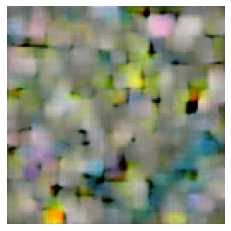

0 10 loss - 4.774929046630859
0 20 loss - 2.7906546592712402
0 30 loss - 2.312739372253418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms two bathrooms two hallways two other rooms . 


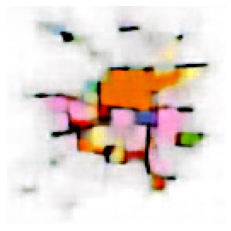

0 40 loss - 2.1264727115631104
0 50 loss - 2.189707040786743
0 60 loss - 1.9103031158447266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bathrooms four other rooms . 


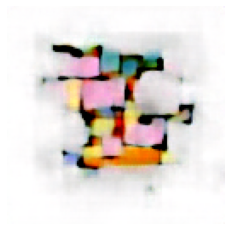

0 70 loss - 2.0221939086914062
0 80 loss - 1.7716283798217773
0 90 loss - 1.6811447143554688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room one bathroom one storage room two other rooms . 


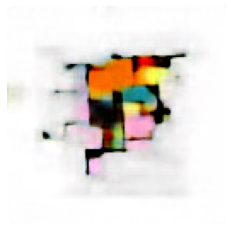

0 100 loss - 1.8274316787719727
0 110 loss - 1.751816987991333
0 120 loss - 1.7483328580856323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway one other room . 


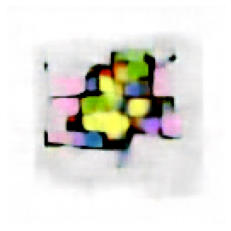

0 130 loss - 1.6907938718795776
0 140 loss - 1.9061505794525146
0 150 loss - 1.7244242429733276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom two bathrooms one storage room two other rooms . 


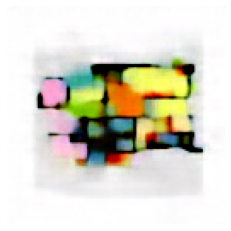

0 160 loss - 1.7252068519592285
0 170 loss - 1.6924662590026855
0 180 loss - 1.7000718116760254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has three yards one kitchen one living room one bedroom one bathroom two hallways one storage room one other room . 


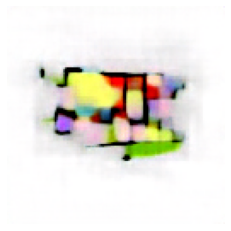

0 190 loss - 1.7656779289245605
0 200 loss - 1.8867838382720947
0 210 loss - 1.7919251918792725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway two other rooms . 


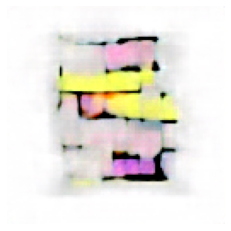

0 220 loss - 1.550415277481079
0 230 loss - 1.5843597650527954
0 240 loss - 1.561835765838623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one bathroom one hallway four other rooms . 


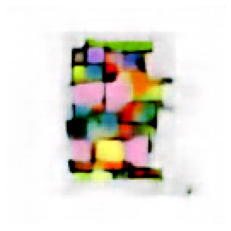

0 250 loss - 1.8349276781082153
0 260 loss - 1.5839300155639648
0 270 loss - 1.8012439012527466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room one bedroom one bathroom one hallway three other rooms . 


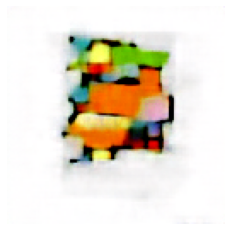

0 280 loss - 1.666357398033142
0 290 loss - 1.574906349182129
0 300 loss - 1.5342024564743042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room four bedrooms two bathrooms two hallways six other rooms . 


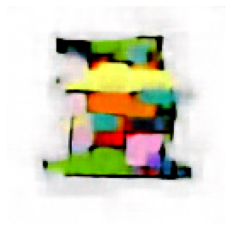

0 310 loss - 1.6858417987823486
0 320 loss - 1.762822151184082
0 330 loss - 1.7134873867034912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms one bedroom one bathroom one storage room one other room . 


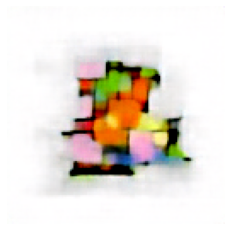

0 340 loss - 1.7905640602111816
0 350 loss - 1.61641263961792
0 360 loss - 1.6592704057693481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room two bathrooms one hallway three other rooms . 


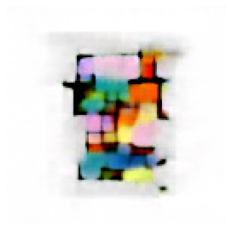

0 370 loss - 1.9009815454483032
0 380 loss - 1.6898964643478394
0 390 loss - 1.605494737625122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms three bathrooms two hallways one storage room one garage four other rooms . 


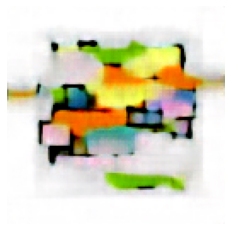

0 400 loss - 1.56668221950531
0 410 loss - 1.923993468284607
0 420 loss - 1.6971863508224487


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one bathroom one hallway two storage rooms . 


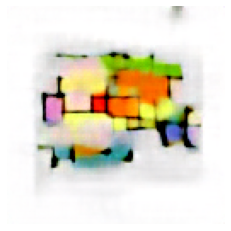

0 430 loss - 1.7227675914764404
0 440 loss - 1.621355652809143
0 450 loss - 1.7004274129867554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one bathroom one hallway one other room . 


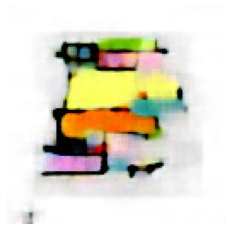

0 460 loss - 1.6910881996154785
0 470 loss - 1.4411399364471436
0 480 loss - 1.5155904293060303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room one bathroom two other rooms . 


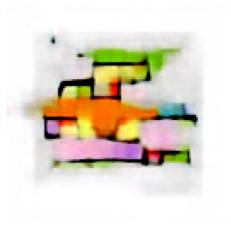

0 490 loss - 1.3467605113983154
0 500 loss - 1.6453040838241577
0 0 val_loss - 1.5732046365737915
0 10 val_loss - 1.7366234064102173
0 20 val_loss - 1.5557074546813965
0 30 val_loss - 1.5183902978897095
0 40 val_loss - 1.6765027046203613
0 50 val_loss - 1.7942606210708618
1 0 loss - 1.6837456226348877


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room three bedrooms two bathrooms three hallways three storage rooms one garage four other rooms . 


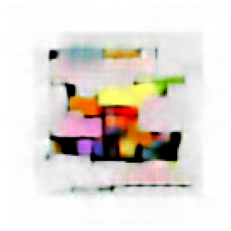

1 10 loss - 1.383783221244812
1 20 loss - 1.8110395669937134
1 30 loss - 1.710553526878357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two kitchens one living room two bedrooms two bathrooms two hallways four storage rooms one garage two other rooms . 


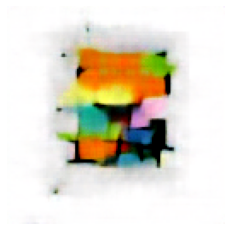

1 40 loss - 1.6513899564743042
1 50 loss - 1.4440655708312988
1 60 loss - 1.6451774835586548


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one storage room two other rooms . 


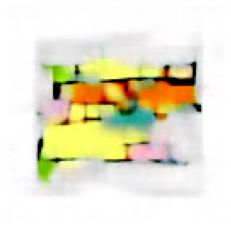

1 70 loss - 1.68036949634552
1 80 loss - 1.779516577720642
1 90 loss - 1.6253008842468262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one storage room two other rooms . 


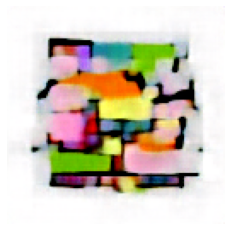

1 100 loss - 1.5960270166397095
1 110 loss - 1.4581291675567627
1 120 loss - 1.6007713079452515


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one bathroom four other rooms . 


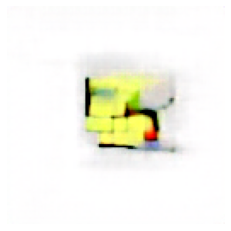

1 130 loss - 1.600859522819519
1 140 loss - 1.8317118883132935
1 150 loss - 1.7283008098602295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms two bathrooms two hallways two storage rooms one other room . 


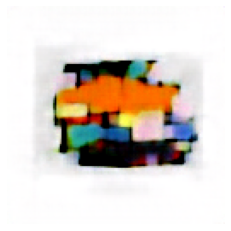

1 160 loss - 1.5681926012039185
1 170 loss - 1.6198045015335083
1 180 loss - 1.607164740562439


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards two kitchens one living room three bedrooms four bathrooms two hallways two storage rooms one garage three other rooms . 


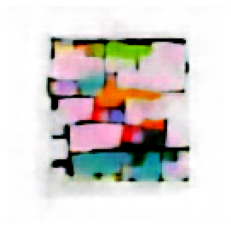

1 190 loss - 1.6682462692260742
1 200 loss - 1.6587787866592407
1 210 loss - 1.5259168148040771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one bathroom two hallways one storage room four other rooms . 


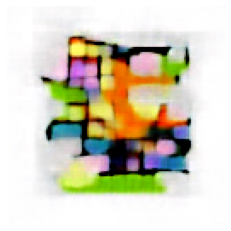

1 220 loss - 1.7269930839538574
1 230 loss - 1.6122524738311768
1 240 loss - 1.7496230602264404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has four yards two bedrooms four bathrooms one hallway four other rooms . 


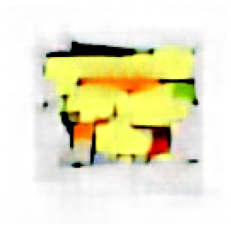

1 250 loss - 1.5110312700271606
1 260 loss - 1.54972243309021
1 270 loss - 1.7214139699935913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one bedroom two bathrooms two storage rooms three other rooms . 


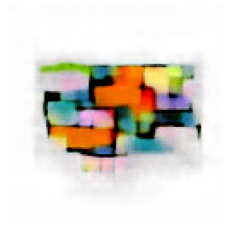

1 280 loss - 1.69040846824646
1 290 loss - 1.679348111152649
1 300 loss - 1.7298145294189453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen two living rooms two bedrooms four other rooms . 


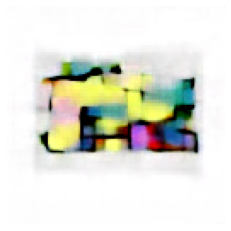

1 310 loss - 1.5014091730117798
1 320 loss - 1.7692747116088867
1 330 loss - 1.5950427055358887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen two living rooms three bedrooms three bathrooms three hallways three storage rooms three other rooms . 


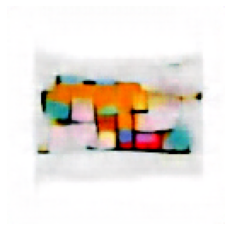

1 340 loss - 1.6887397766113281
1 350 loss - 1.6522011756896973
1 360 loss - 1.6400202512741089


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room four bedrooms three bathrooms three hallways two storage rooms three other rooms . 


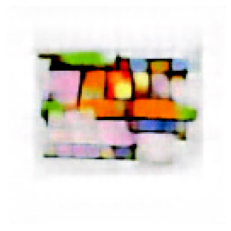

1 370 loss - 1.5478378534317017
1 380 loss - 1.6280980110168457
1 390 loss - 1.866654872894287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms two bedrooms two bathrooms one hallway one storage room four other rooms . 


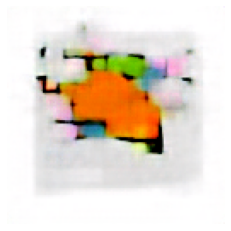

1 400 loss - 1.5746445655822754
1 410 loss - 1.4111825227737427
1 420 loss - 1.5107589960098267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one bathroom one hallway two other rooms . 


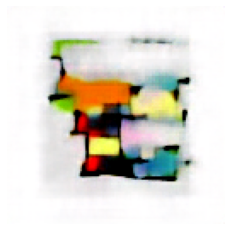

1 430 loss - 1.4568729400634766
1 440 loss - 1.790063500404358
1 450 loss - 1.4737299680709839


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one bathroom three other rooms . 


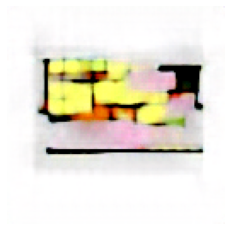

1 460 loss - 1.465979814529419
1 470 loss - 1.4206427335739136
1 480 loss - 1.6479408740997314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms two bathrooms two hallways one storage room one garage two other rooms . 


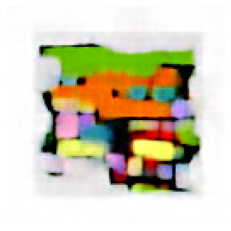

1 490 loss - 1.5777584314346313
1 500 loss - 1.659773349761963
1 0 val_loss - 1.6875168085098267
1 10 val_loss - 1.572647213935852
1 20 val_loss - 1.4859033823013306
1 30 val_loss - 1.4596450328826904
1 40 val_loss - 1.5419268608093262
1 50 val_loss - 1.708316683769226
2 0 loss - 1.5859804153442383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room one bedroom one bathroom one hallway one storage room one other room . 


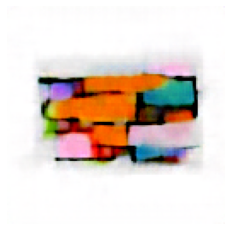

2 10 loss - 1.360808253288269
2 20 loss - 1.5023599863052368
2 30 loss - 1.5283037424087524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one bedroom two other rooms . 


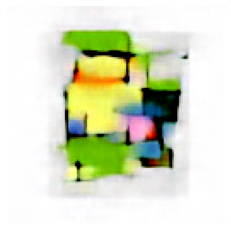

2 40 loss - 1.5391042232513428
2 50 loss - 1.5510107278823853
2 60 loss - 1.5119571685791016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway one storage room three other rooms . 


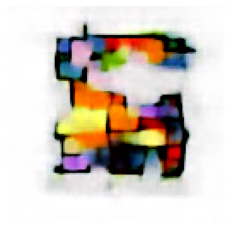

2 70 loss - 1.766979455947876
2 80 loss - 1.5727734565734863
2 90 loss - 1.6408007144927979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room three bedrooms three bathrooms one hallway one storage room one garage four other rooms . 


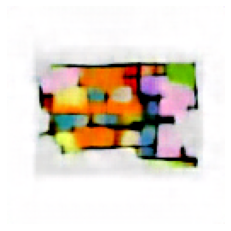

2 100 loss - 1.5942420959472656
2 110 loss - 1.6463624238967896
2 120 loss - 1.5846247673034668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway one storage room one other room . 


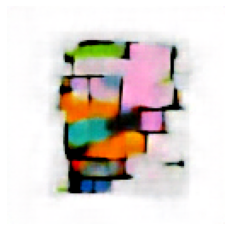

2 130 loss - 1.4688318967819214
2 140 loss - 1.5383689403533936
2 150 loss - 1.5522722005844116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room one bedroom one bathroom one hallway one storage room one other room . 


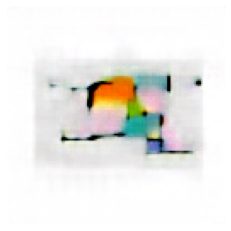

2 160 loss - 1.6542693376541138
2 170 loss - 1.6133915185928345
2 180 loss - 1.544951319694519


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard seven other rooms . 


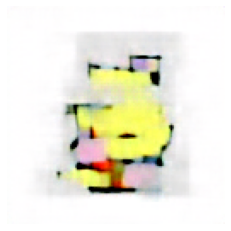

2 190 loss - 1.5587865114212036
2 200 loss - 1.61088228225708
2 210 loss - 1.7586565017700195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen three bathrooms three hallways twelve other rooms . 


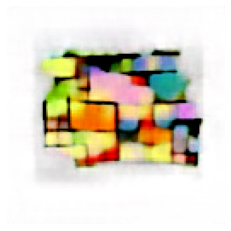

2 220 loss - 1.4218167066574097
2 230 loss - 1.6688860654830933
2 240 loss - 1.4984899759292603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room three bedrooms two hallways one garage two other rooms . 


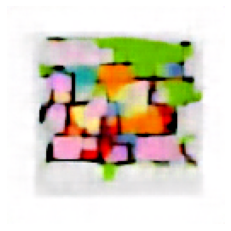

2 250 loss - 1.5439058542251587
2 260 loss - 1.6342675685882568
2 270 loss - 1.518610954284668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway one storage room four other rooms . 


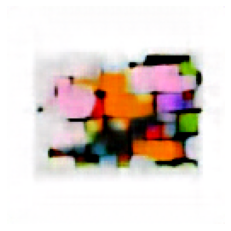

2 280 loss - 1.7791550159454346
2 290 loss - 1.5360746383666992
2 300 loss - 1.4315054416656494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one bathroom one hallway two other rooms . 


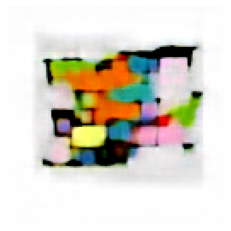

2 310 loss - 1.5382517576217651
2 320 loss - 1.5326811075210571
2 330 loss - 1.4515504837036133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one storage room two other rooms . 


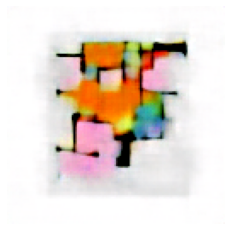

2 340 loss - 1.3956241607666016
2 350 loss - 1.58638334274292
2 360 loss - 1.6559333801269531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom two bathrooms one hallway one storage room one other room . 


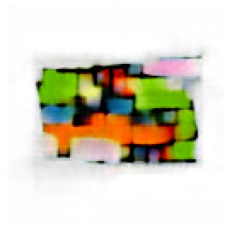

2 370 loss - 1.393122673034668
2 380 loss - 1.5302621126174927
2 390 loss - 1.45533287525177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms two bathrooms one hallway one storage room . 


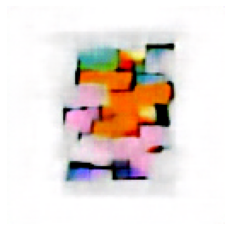

2 400 loss - 1.7304142713546753
2 410 loss - 1.7774090766906738
2 420 loss - 1.5083459615707397


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one bathroom one hallway one storage room one other room . 


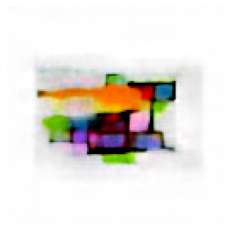

2 430 loss - 1.4980134963989258
2 440 loss - 1.5548992156982422
2 450 loss - 1.4467368125915527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one bathroom one hallway one storage room two other rooms . 


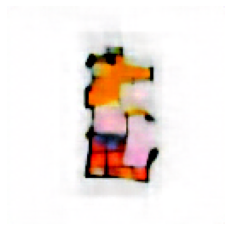

2 460 loss - 1.5472958087921143
2 470 loss - 1.5548332929611206
2 480 loss - 1.484164834022522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room one bedroom two bathrooms one hallway one storage room . 


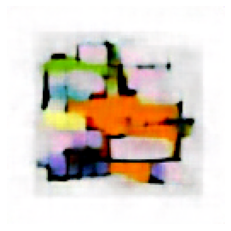

2 490 loss - 1.6291550397872925
2 500 loss - 1.39519202709198
2 0 val_loss - 1.5935611724853516
2 10 val_loss - 1.633121371269226
2 20 val_loss - 1.7691570520401
2 30 val_loss - 1.401366949081421
2 40 val_loss - 1.4437506198883057
2 50 val_loss - 1.6143676042556763
3 0 loss - 1.5880107879638672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one bathroom five other rooms . 


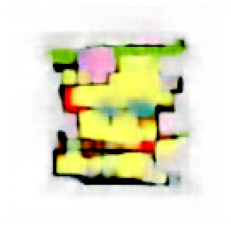

3 10 loss - 1.4165323972702026
3 20 loss - 1.433919906616211
3 30 loss - 1.5538088083267212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has three yards one living room three bedrooms two bathrooms one hallway two storage rooms one garage five other rooms . 


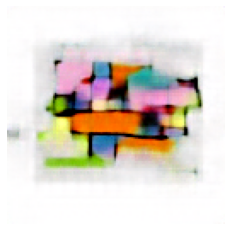

3 40 loss - 1.5497891902923584
3 50 loss - 1.6124138832092285
3 60 loss - 1.4789752960205078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway . 


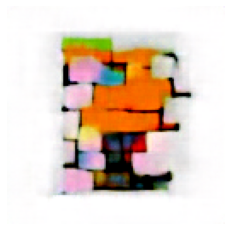

3 70 loss - 1.5202747583389282
3 80 loss - 1.5191415548324585
3 90 loss - 1.3545341491699219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room one bedroom one bathroom two hallways two storage rooms two other rooms . 


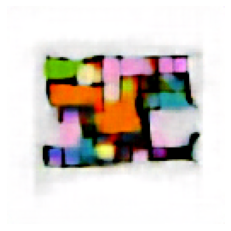

3 100 loss - 1.6081011295318604
3 110 loss - 1.4967310428619385
3 120 loss - 1.7354633808135986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms two bedrooms one bathroom one hallway one other room . 


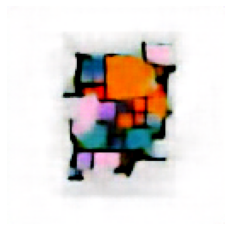

3 130 loss - 1.5003124475479126
3 140 loss - 1.470343828201294
3 150 loss - 1.6828608512878418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway one other room . 


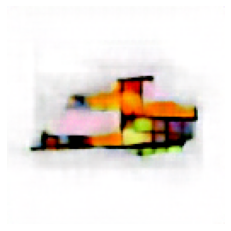

3 160 loss - 1.3556162118911743
3 170 loss - 1.5809646844863892
3 180 loss - 1.526533842086792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard five other rooms . 


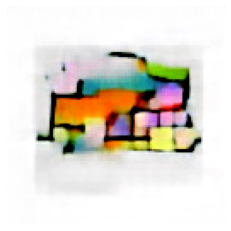

3 190 loss - 1.7491352558135986
3 200 loss - 1.632107138633728
3 210 loss - 1.3594555854797363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bathroom two hallways . 


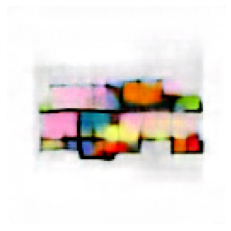

3 220 loss - 1.3984297513961792
3 230 loss - 1.286192774772644
3 240 loss - 1.4031585454940796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has three yards two kitchens one living room two bedrooms two bathrooms two hallways one storage room two other rooms . 


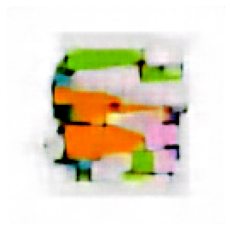

3 250 loss - 1.4392180442810059
3 260 loss - 1.5946465730667114
3 270 loss - 1.3630945682525635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room two bedrooms one bathroom one hallway . 


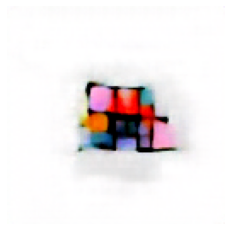

3 280 loss - 1.59111750125885
3 290 loss - 1.5917054414749146
3 300 loss - 1.6059203147888184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has three yards one kitchen one living room four bedrooms two bathrooms two hallways one storage room one garage four other rooms . 


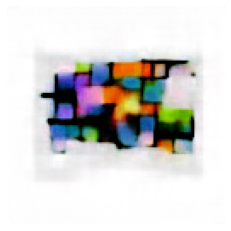

3 310 loss - 1.5229305028915405
3 320 loss - 1.620029330253601
3 330 loss - 1.5460097789764404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room seven other rooms . 


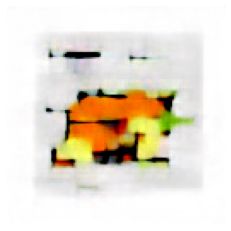

3 340 loss - 1.5491514205932617
3 350 loss - 1.600750207901001
3 360 loss - 1.5212364196777344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms one bathroom two hallways two storage rooms two other rooms . 


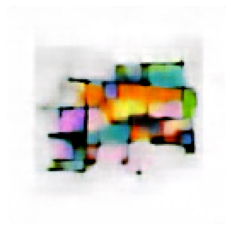

3 370 loss - 1.4681645631790161
3 380 loss - 1.5641266107559204
3 390 loss - 1.3716845512390137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has three yards one kitchen two living rooms three bedrooms four bathrooms three hallways two storage rooms five other rooms . 


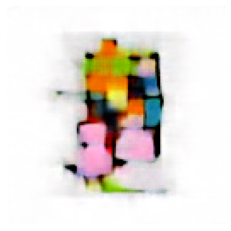

3 400 loss - 1.437779426574707
3 410 loss - 1.500985860824585
3 420 loss - 1.2773500680923462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms one bedroom two bathrooms two hallways one storage room one other room . 


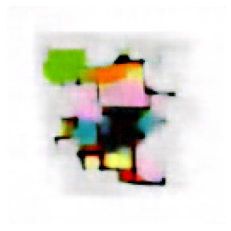

3 430 loss - 1.4215251207351685
3 440 loss - 1.6214308738708496
3 450 loss - 1.4895918369293213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen two living rooms two bedrooms one bathroom two hallways one storage room one other room . 


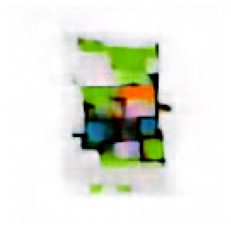

3 460 loss - 1.542739748954773
3 470 loss - 1.5515550374984741
3 480 loss - 1.5828344821929932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms six other rooms . 


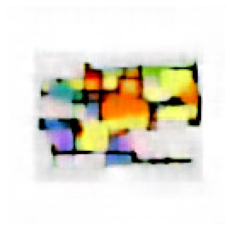

3 490 loss - 1.506225824356079
3 500 loss - 1.5492023229599
3 0 val_loss - 1.320939540863037
3 10 val_loss - 1.5310019254684448
3 20 val_loss - 1.6222816705703735
3 30 val_loss - 1.4101495742797852
3 40 val_loss - 1.382457971572876
3 50 val_loss - 1.4358412027359009
4 0 loss - 1.4033359289169312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room two bedrooms one bathroom two hallways one storage room one other room . 


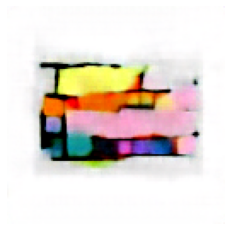

4 10 loss - 1.3605483770370483
4 20 loss - 1.4369159936904907
4 30 loss - 1.4917821884155273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has four yards one kitchen two living rooms one bedroom three bathrooms one hallway two storage rooms one garage six other rooms . 


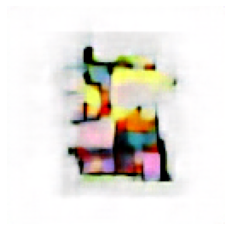

4 40 loss - 1.491862416267395
4 50 loss - 1.672910451889038
4 60 loss - 1.6779484748840332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has three yards one living room three bedrooms two bathrooms two hallways three storage rooms one garage four other rooms . 


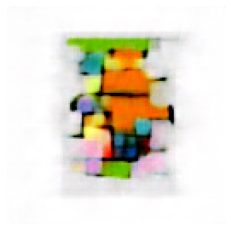

4 70 loss - 1.5991151332855225
4 80 loss - 1.5298715829849243
4 90 loss - 1.4425071477890015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room three bedrooms two bathrooms two hallways two other rooms . 


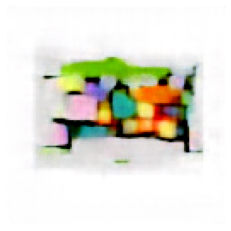

4 100 loss - 1.6555882692337036
4 110 loss - 1.2641878128051758
4 120 loss - 1.323156476020813


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bathroom one hallway . 


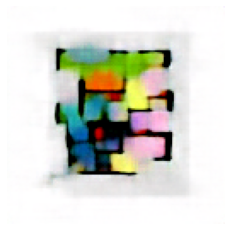

4 130 loss - 1.6000348329544067
4 140 loss - 1.6170037984848022
4 150 loss - 1.5772764682769775


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen one living room one bedroom two hallways two storage rooms three other rooms . 


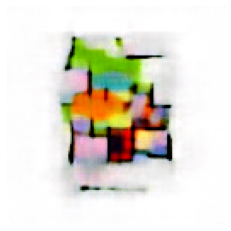

4 160 loss - 1.5127968788146973
4 170 loss - 1.4496123790740967
4 180 loss - 1.3834940195083618


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bathroom one hallway . 


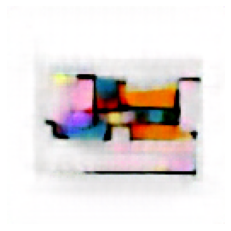

4 190 loss - 1.6169248819351196
4 200 loss - 1.5042555332183838
4 210 loss - 1.5127955675125122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms one bedroom one bathroom one hallway . 


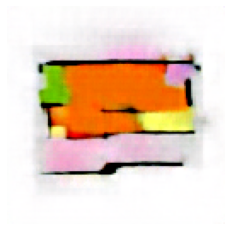

4 220 loss - 1.613968849182129
4 230 loss - 1.4599748849868774
4 240 loss - 1.414998173713684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one hallway one storage room . 


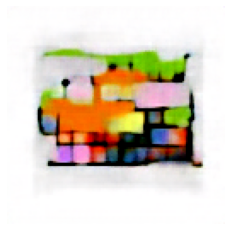

4 250 loss - 1.5299955606460571
4 260 loss - 1.5047789812088013
4 270 loss - 1.2604817152023315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one storage room one other room . 


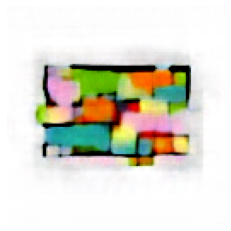

4 280 loss - 1.394406795501709
4 290 loss - 1.7078547477722168
4 300 loss - 1.433129072189331


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one living room two bedrooms one bathroom one hallway one storage room two other rooms . 


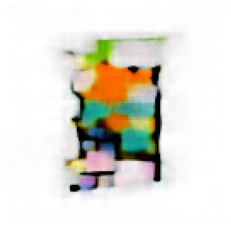

4 310 loss - 1.3606172800064087
4 320 loss - 1.5550187826156616
4 330 loss - 1.5975807905197144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one kitchen one living room two bedrooms two bathrooms two hallways one storage room one garage one other room . 


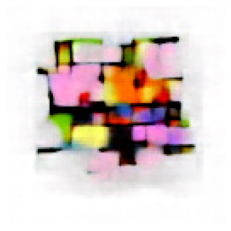

4 340 loss - 1.409374713897705
4 350 loss - 1.348246455192566
4 360 loss - 1.5972034931182861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms one bedroom one hallway one storage room two other rooms . 


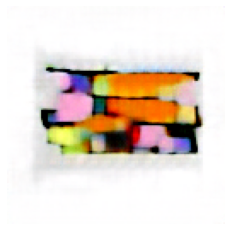

4 370 loss - 1.395342230796814
4 380 loss - 1.6050286293029785
4 390 loss - 1.4564399719238281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom two hallways two other rooms . 


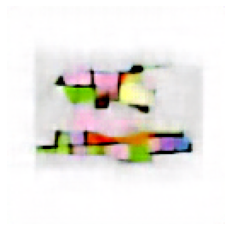

4 400 loss - 1.5146982669830322
4 410 loss - 1.5839561223983765
4 420 loss - 1.52397882938385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has two yards one kitchen two living rooms one bedroom two bathrooms two hallways one other room . 


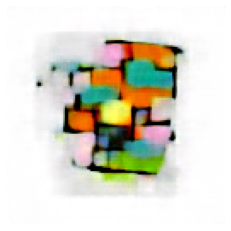

4 430 loss - 1.6022465229034424
4 440 loss - 1.4961590766906738
4 450 loss - 1.3359273672103882


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen two living rooms one bedroom one bathroom one hallway one storage room . 


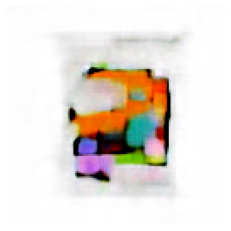

4 460 loss - 1.4725418090820312
4 470 loss - 1.4636603593826294
4 480 loss - 1.3586132526397705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the house has one floor . the first floor has one yard one kitchen one living room one bedroom one bathroom one storage room one other room . 


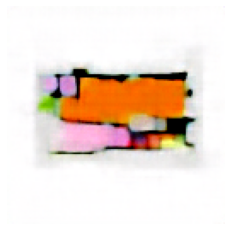

4 490 loss - 1.3805303573608398
4 500 loss - 1.44330632686615
4 0 val_loss - 1.538231372833252
4 10 val_loss - 1.5006539821624756
4 20 val_loss - 1.6723151206970215
4 30 val_loss - 1.3660908937454224
4 40 val_loss - 1.5837253332138062
4 50 val_loss - 1.5717833042144775


In [ ]:
# Setup Adam optimizer
opt = Adam(dalle.parameters(), lr=args.LEARNING_RATE)

# Setup optional LR decay scheduler
if args.LR_DECAY:
    scheduler = ReduceLROnPlateau(
        opt,
        mode = "min",
        factor = 0.5,
        patience = 10,
        cooldown = 10,
        min_lr = 1e-6,
        verbose = True,
    )

# Start wandb job
if args.distr_backend.is_root_worker():
    import wandb

    run = wandb.init(
        entity=args.WANDB_OWNER,
        project = args.WANDB_PROJ_NAME,
        resume = args.RESUME,
        config = dalle_params,
    )

args.distr_backend.check_batch_size(args.BATCH_SIZE)
deepspeed_config = {
    'train_batch_size': args.BATCH_SIZE,
    'gradient_clipping': args.GRAD_CLIP_NORM,
    'fp16': {
        'enabled': args.fp16,
    },
}

(distr_dalle, opt, dl, scheduler) = args.distr_backend.distribute(
    # args=args,
    model=dalle,
    optimizer=opt,
    model_parameters=dalle.parameters(),
    training_data=train_ds if args.using_deepspeed else dl,
    lr_scheduler=scheduler if args.LR_DECAY else None,
    config_params=deepspeed_config,
)
avoid_model_calls = args.using_deepspeed and args.fp16

# Setup training loop
torch.cuda.empty_cache()
for epoch in range(args.EPOCHS):
    model_path = './model/dalle-checkpoint/dalle-epoch-{}.pt'.format(epoch)

    # Train in mini-batches
    for i, (text, images) in enumerate(dl):
        if args.fp16:
            images = images.half()
        text, images = map(lambda t: t.cuda(), (text, images))

        # Get loss from (text, images) from DALL-E
        loss = distr_dalle(text, images, return_loss = True)

        # Update network weights from losses
        if args.using_deepspeed:
            distr_dalle.backward(loss)
            distr_dalle.step()
        else:
            loss.backward()
            clip_grad_norm_(distr_dalle.parameters(), args.GRAD_CLIP_NORM)
            opt.step()
            opt.zero_grad()

        # Get average loss
        avg_loss = args.distr_backend.average_all(loss)

        # Log samples and metrics to wandb
        if args.distr_backend.is_root_worker():
            log = {}

            if i % 10 == 0:
                print(epoch, i, f'loss - {avg_loss.item()}')

                log = {
                    **log,
                    'epoch': epoch,
                    'iter': i,
                    'loss': avg_loss.item()
                }

            if i % 30 == 0:
                sample_text = text[:1]
                token_list = sample_text.masked_select(sample_text != 0).tolist()
                decoded_text = tokenizer.decode(token_list)

                save_dalle_model(model_path)
                wandb.save(model_path)

                log = {
                    **log,
                }

                image = dalle.generate_images(text[:1], filter_thres = 0.9) 
                arr_ = np.squeeze(image[0].permute(1,2,0).cpu())
                print(decoded_text)
                plt.imshow(arr_)
                plt.axis('off')
                plt.show()

                log['image'] = wandb.Image(image, caption = decoded_text)
                
            wandb.log(log)

    # Update LR based on scheduled decay
    if args.LR_DECAY:
        scheduler.step(loss)

    # Validation step
    for val_batch_idx, (val_text, val_images) in enumerate(val_dl):
        if args.fp16:
            val_images = val_images.half()
        val_text, val_images = map(lambda t: t.cuda(), (val_text, val_images))

        loss = distr_dalle(val_text, val_images, return_loss = True)

        if not args.using_deepspeed:
            opt.zero_grad()

        avg_loss = args.distr_backend.average_all(loss)

        if args.distr_backend.is_root_worker():
            if val_batch_idx % 10 == 0:
                print(epoch, val_batch_idx, f'val_loss - {avg_loss.item()}')

                logs = {
                    'val_epoch': epoch,
                    'val_iter': val_batch_idx,
                    'val_loss': avg_loss.item()
                }

                wandb.log(logs)

    # Save model as wandb artifact at end of every epoch
    if args.distr_backend.is_root_worker():
        model_artifact = wandb.Artifact('trained-dalle', type = 'model', metadata = dict(dalle_params))
        model_artifact.add_file(model_path)
        run.log_artifact(model_artifact)

# Save final trained DALL-E model
if args.distr_backend.is_root_worker():
    save_dalle_model(f'./model/dalle-final.pt')
    wandb.save('./model/dalle-final.pt')
    model_artifact = wandb.Artifact('trained-dalle', type = 'model', metadata = dict(dalle_params))
    model_artifact.add_file('./model/dalle-final.pt')
    run.log_artifact(model_artifact)

    wandb.finish()

In [ ]:
# Save model to Google Drive
path = '/content/drive/MyDrive/CMPE 258 Deep Learning/DALL-E/model/cubicasa/dalle/2021-04-28.pt'
save_dalle_model(path)